# Metadata

Model number of shootings per state given political spending by party in a given state.  

Data Sources: 

    Gun Violence Awareness  
    Political Media Spending (3rd party) from 2020 Presidential General Election

Modeling based on the following:  
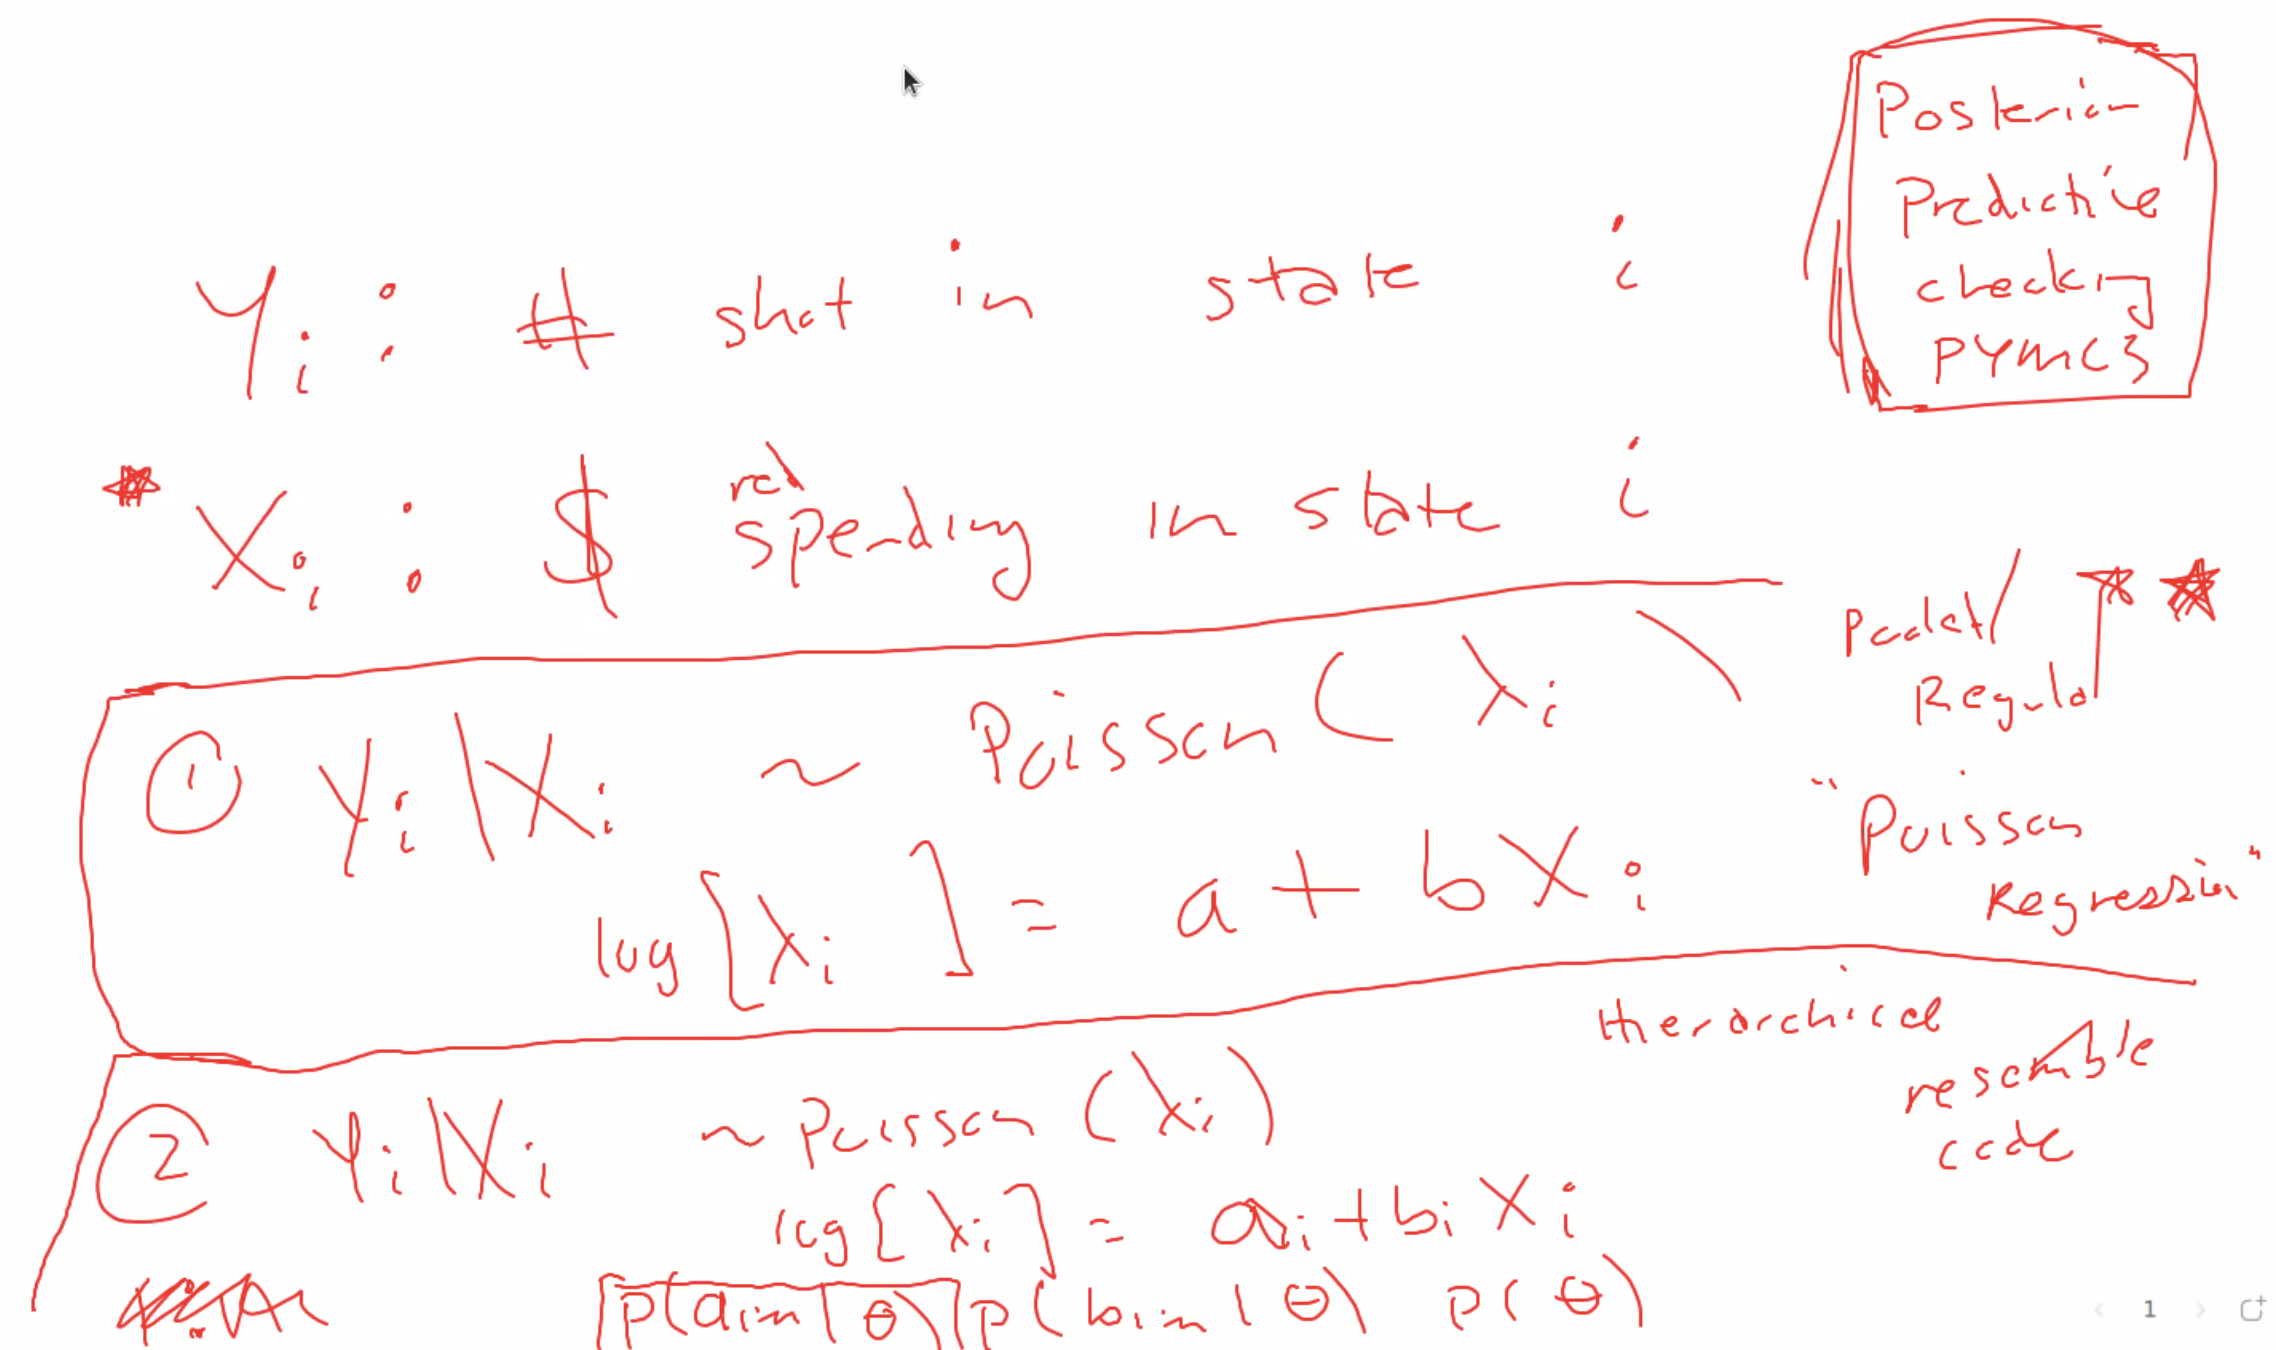

Poisson distribution is useful when counting things. In this case, we're counting the number of victims in all shootings (from 2020 to 7/8/22) for each state. Model requires using discrete non-negative numbers: {0,1,2,3...} (aka count data).

https://learning.oreilly.com/library/view/bayesian-analysis-with/9781789341652/2252e56c-3e2d-40ae-812b-38a5bd4e63d2.xhtml

https://www.youtube.com/watch?v=ZxR3mw-Znzc

Workflow:  
1. Plot the data
2. Build model
3. Run prior predictive check
4. Fit model
5. Assess convergence (cool stuff?)
6. Run posterior predictive check
7. Improve model


In [1]:
#import libraries
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, poisson
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from formulae import design_matrices
import arviz as az
import bambi as bmb
import math

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
df = pd.read_csv("state_level_data.csv")
party = pd.read_csv("presidential_state_results_2020.csv")

In [3]:
#df.columns

In [4]:
#party

In [5]:
#drop index column
df = df[['state', 'total_involved', 'abbrev', 'democrat','republican']]

In [6]:
#add column for red/blue state (visualization purposes only)
df = df.join(other = party.set_index('state'), on = 'abbrev', how = 'left')

## Difference in spending New Variable
+ If positive, more Dem spending
+ if negative, more Rep spending 

In [7]:
#add in difference in dem / repub try as predictor
df['party_spending_differences'] = df.democrat - df.republican
#df

In [8]:
#marker for higher repub spending 
df['higher_rep_spend'] = [x<0 for x in df.party_spending_differences]
#df

In [9]:
#now take absolute value -> so can transform with log
df['abs_spend_diff']=[abs(x) for x in df.party_spending_differences]
df

,state,total_involved,abbrev,democrat,republican,party,party_spending_differences,higher_rep_spend,abs_spend_diff
0,Alabama,195,AL,3.847529e+05,1.336843e+06,r,-9.520898e+05,True,9.520898e+05
1,Alaska,18,AK,9.699815e+04,2.169688e+05,r,-1.199707e+05,True,1.199707e+05
2,Arizona,106,AZ,9.079025e+07,6.144790e+07,b,2.934235e+07,False,2.934235e+07
3,Arkansas,127,AR,3.368742e+05,5.981153e+05,r,-2.612411e+05,True,2.612411e+05
4,California,557,CA,1.067421e+07,8.769293e+06,b,1.904918e+06,False,1.904918e+06
5,Colorado,168,CO,4.200255e+06,1.118881e+06,b,3.081373e+06,False,3.081373e+06
6,Connecticut,50,CT,5.880892e+05,3.885284e+05,b,1.995608e+05,False,1.995608e+05
7,Delaware,43,DE,2.135545e+05,1.185754e+05,b,9.497903e+04,False,9.497903e+04
8,District of Columbia,156,DC,7.453544e+06,2.962742e+06,b,4.490802e+06,False,4.490802e+06
9,Florida,413,FL,2.289976e+08,1.205918e+08,r,1.084058e+08,False,1.084058e+08


In [10]:
df['log_diff'] = [np.log(x) for x in df['abs_spend_diff']] 

In [11]:
df['log_rep'] = [np.log(x) for x in df['republican']] 

In [12]:
df['log_inv'] = [np.log(x) for x in df['total_involved']] 

In [13]:
df

,state,total_involved,abbrev,democrat,republican,party,party_spending_differences,higher_rep_spend,abs_spend_diff,log_diff,log_rep,log_inv
0,Alabama,195,AL,3.847529e+05,1.336843e+06,r,-9.520898e+05,True,9.520898e+05,13.766415,14.105821,5.273000
1,Alaska,18,AK,9.699815e+04,2.169688e+05,r,-1.199707e+05,True,1.199707e+05,11.695003,12.287509,2.890372
2,Arizona,106,AZ,9.079025e+07,6.144790e+07,b,2.934235e+07,False,2.934235e+07,17.194542,17.933700,4.663439
3,Arkansas,127,AR,3.368742e+05,5.981153e+05,r,-2.612411e+05,True,2.612411e+05,12.473199,13.301539,4.844187
4,California,557,CA,1.067421e+07,8.769293e+06,b,1.904918e+06,False,1.904918e+06,14.459949,15.986767,6.322565
5,Colorado,168,CO,4.200255e+06,1.118881e+06,b,3.081373e+06,False,3.081373e+06,14.940886,13.927840,5.123964
6,Connecticut,50,CT,5.880892e+05,3.885284e+05,b,1.995608e+05,False,1.995608e+05,12.203874,12.870121,3.912023
7,Delaware,43,DE,2.135545e+05,1.185754e+05,b,9.497903e+04,False,9.497903e+04,11.461411,11.683305,3.761200
8,District of Columbia,156,DC,7.453544e+06,2.962742e+06,b,4.490802e+06,False,4.490802e+06,15.317542,14.901626,5.049856
9,Florida,413,FL,2.289976e+08,1.205918e+08,r,1.084058e+08,False,1.084058e+08,18.501393,18.607922,6.023448


In [14]:
#save df with party info
#df.to_csv('state_spending_with_party.csv')

# 1. Plot Data

<AxesSubplot:xlabel='log_diff', ylabel='log_inv'>

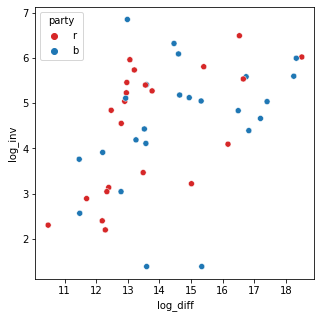

In [15]:
#define palette colors
palette = {'b':'tab:blue',
          'r':'tab:red'}

#scatterplot
plt.figure(figsize = (5,5))
sns.scatterplot(data = df, 
                #x = 'abs_spend_diff',
                x = 'log_diff',
                #y = 'total_involved',
                y = 'log_inv',
                hue = 'party',
               palette = palette)

#add text labels
# for i in range(df.shape[0]):
#     if df.party_spending_differences[i] > 0.2e8:
#         plt.text(x = df.republican[i]+5,
#                 y = df.total_involved[i]+15,
#                 s = df.state[i],
#                 fontdict=dict(color = 'black', size = 10))

<AxesSubplot:xlabel='log_rep', ylabel='log_inv'>

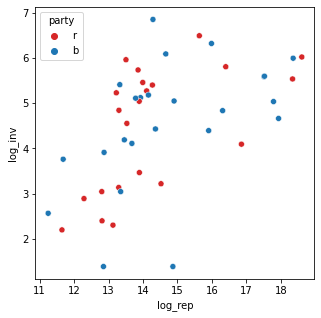

In [16]:
#define palette colors
palette = {'b':'tab:blue',
          'r':'tab:red'}

#scatterplot
plt.figure(figsize = (5,5))
sns.scatterplot(data = df, 
                x = 'log_rep', 
                y = 'log_inv',
                hue = 'party',
               palette = palette)

<AxesSubplot:xlabel='total_involved', ylabel='Count'>

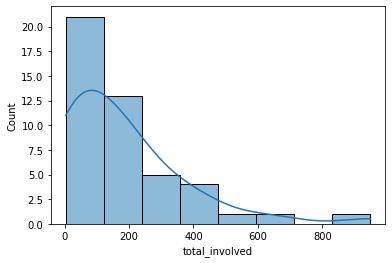

In [17]:
sns.histplot(data = df, x = 'total_involved', kde = True)

<AxesSubplot:xlabel='log_inv', ylabel='Count'>

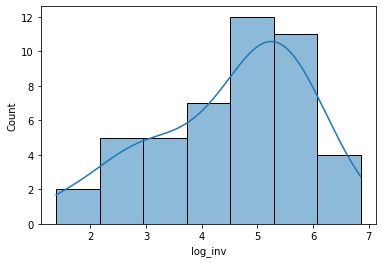

In [18]:
sns.histplot(data = df, x = 'log_inv', kde = True)

<AxesSubplot:xlabel='total_involved', ylabel='Count'>

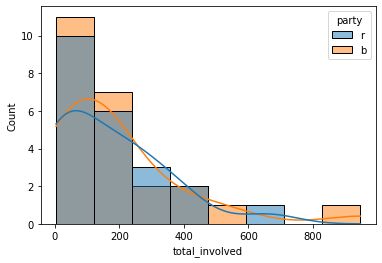

In [19]:
sns.histplot(data = df, x = 'total_involved', kde = True, hue = 'party')

<AxesSubplot:xlabel='log_inv', ylabel='Count'>

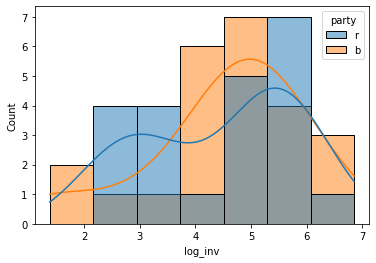

In [20]:
sns.histplot(data = df, x = 'log_inv', kde = True, hue = 'party')

# 2. Build Model

The probability mass function of Poisson distribution is as follows:  

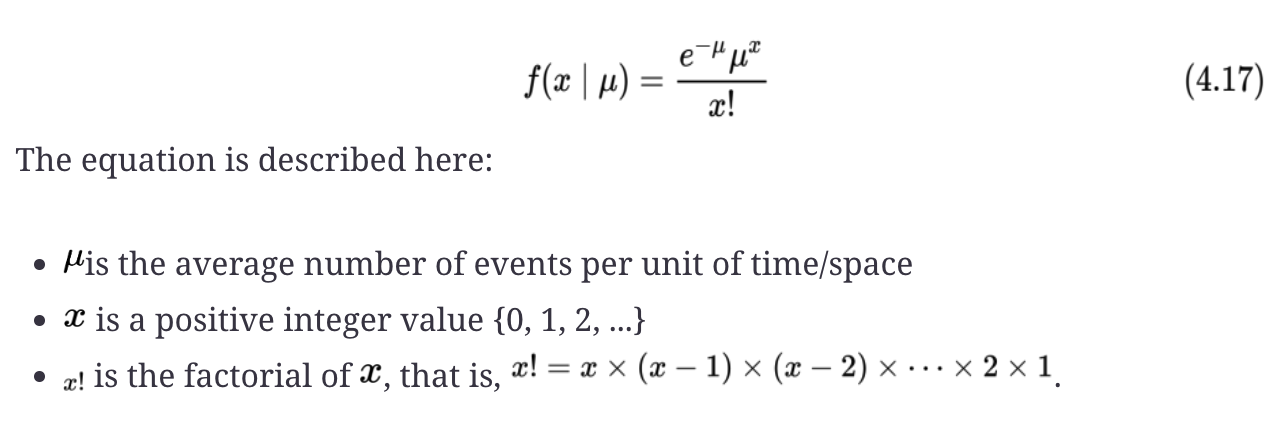

https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-poisson-regression.html

In [21]:
#create model (full formulae formulation)
fml = 'log_inv ~ log_rep'

In [22]:
#create design matrices
dm = design_matrices(fml, df, na_action = 'error')

In [23]:
dm

DesignMatrices

                  (rows, cols)
Response:                (46,)
Common:                (46, 2)

Use .reponse, .common, or .group to access the different members.

In [24]:
mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

In [25]:
mx_ex.head()

,Intercept,log_rep
0,1.0,14.105821
1,1.0,12.287509
2,1.0,17.933700
3,1.0,13.301539
4,1.0,15.986767


In [26]:
mx_ex.Intercept.value_counts()

1.0    46
Name: Intercept, dtype: int64

In [27]:
mx_en.head()

,log_inv
0,5.273000
1,2.890372
2,4.663439
3,4.844187
4,6.322565


In [28]:
#create model

with pm.Model() as pois_log:
    
    #define priors
    b0 = pm.Normal("intercept", mu = 0, sigma = 10)
    b1 = pm.Normal("log_rep", mu = 0, sigma = 10)

    #define logistic model
    log_lambda = (b0 + b1*df['log_rep'].values)
    
    #define poisson likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df['log_inv'].values)

In [29]:
#sample model
with pois_log:
    test = pm.sample(2000, init='adapt_diag', tune = 2000, target_accept = 0.95)# start= {'Intercept': np.array([0.225]), 'republican': np.array([10000000.])})

C:\Users\fav21\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_rep, intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


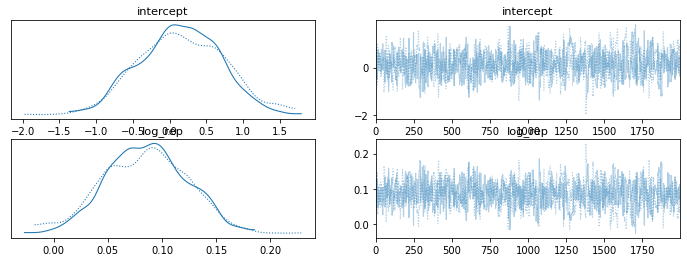

In [30]:
with pois_log:
    az.plot_trace(test)

In [31]:
#with pois_log:
az.summary(test)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.150,0.557,-0.898,1.124,0.023,0.017,562.0,685.0,1.01
log_rep,0.086,0.037,0.020,0.155,0.002,0.001,560.0,688.0,1.01


## Hierarchical

https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   state                       46 non-null     object 
 1   total_involved              46 non-null     int64  
 2   abbrev                      46 non-null     object 
 3   democrat                    46 non-null     float64
 4   republican                  46 non-null     float64
 5   party                       46 non-null     object 
 6   party_spending_differences  46 non-null     float64
 7   higher_rep_spend            46 non-null     bool   
 8   abs_spend_diff              46 non-null     float64
 9   log_diff                    46 non-null     float64
 10  log_rep                     46 non-null     float64
 11  log_inv                     46 non-null     float64
dtypes: bool(1), float64(7), int64(1), object(3)
memory usage: 4.1+ KB


In [33]:
df2 = df[['party', 'log_inv', 'log_rep']]

In [34]:
#you get a warning if you do the top line
#df2['party'] = df2['party'].astype('category')

#do this one instead
df2 = df2.assign(party = df2.party.astype('category'))

In [35]:
df2.head()

,party,log_inv,log_rep
0,r,5.273000,14.105821
1,r,2.890372,12.287509
2,b,4.663439,17.933700
3,r,4.844187,13.301539
4,b,6.322565,15.986767


In [36]:
party_idxs, parties = pd.factorize(df2.party)
coords = {
    "party": parties,
    "obs_id": np.arange(len(party_idxs)),
}

In [37]:
# 1 -> blue (dem) 
# 0 -> red (rep)
party_idxs

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1], dtype=int64)

In [38]:
parties

CategoricalIndex(['r', 'b'], categories=['b', 'r'], ordered=False, dtype='category')

In [39]:
coords

{'party': CategoricalIndex(['r', 'b'], categories=['b', 'r'], ordered=False, dtype='category'),
 'obs_id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])}

In [40]:
with pm.Model():
    party_idx = pm.Data("party_idx", party_idxs)
    print(party_idx)

party_idx


In [41]:
with pm.Model() as hierarchical_model:
    party_idx = pm.Data("party_idx", party_idxs)
    
    # Hyperparameters for groups (states)
    #mu_b0 = pm.Normal("mu_b0", mu=0.0, sigma=100)
    #sigma_b0 = pm.HalfNormal("sigma_b0", 5.0)
    #mu_b1 = pm.Normal("mu_b1", mu=0.0, sigma=100)
    #sigma_b1 = pm.HalfNormal("sigma_b1", 5.0)
    
    mu_b0 = pm.Normal("mu_b0", mu=0.0, sigma=100)
    sigma_b0 = pm.HalfNormal("sigma_b0", 100)
    mu_b1 = pm.Normal("mu_b1", mu=0.0, sigma=100)
    sigma_b1 = pm.HalfNormal("sigma_b1", 100)

    #b0 = pm.Normal("b0", mu=mu_b0, sigma=sigma_b0, shape = df2.log_inv.shape)
    #b1 = pm.Normal("b1", mu=mu_b1, sigma=sigma_b1, shape = df2.log_inv.shape)
    #f_offset = pm.Normal('f_offset', mu=0, sd=1)
    #f = pm.Deterministic("f", f_offset * 5)
    b0_offset = pm.Normal('b0_offset', mu= 0, sd= 1, shape = 2)
    b0 = pm.Deterministic("b0", mu_b0 + b0_offset*sigma_b0)
    
    b1_offset = pm.Normal('b1_offset', mu= 0, sd= 1, shape = 2)
    b1 = pm.Deterministic("b1", mu_b1 + b1_offset*sigma_b1)
    #b1 = pm.Normal("b1", mu=mu_b1, sigma=sigma_b1, shape = 2)

    
    #define logistic model
    #log_lambda = b0[party_idxs] + b1[party_idxs] * df2.log_rep.values 
    log_lambda = b0[party_idx] + b1[party_idx] * df2.log_rep.values 
        
    #Data Likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df2.log_inv) 

In [42]:
with hierarchical_model:
        trace = pm.sample(8000, init='adapt_diag', tune = 8000, target_accept = 0.95) 

C:\Users\fav21\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b1_offset, b0_offset, sigma_b1, mu_b1, sigma_b0, mu_b0]


Sampling 2 chains for 8_000 tune and 8_000 draw iterations (16_000 + 16_000 draws total) took 1097 seconds.
There were 610 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8813980867386281, but should be close to 0.95. Try to increase the number of tuning steps.
There were 558 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8816527345973916, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_b0'}>,
        <AxesSubplot:title={'center':'mu_b0'}>],
       [<AxesSubplot:title={'center':'mu_b1'}>,
        <AxesSubplot:title={'center':'mu_b1'}>],
       [<AxesSubplot:title={'center':'b0_offset'}>,
        <AxesSubplot:title={'center':'b0_offset'}>],
       [<AxesSubplot:title={'center':'b1_offset'}>,
        <AxesSubplot:title={'center':'b1_offset'}>],
       [<AxesSubplot:title={'center':'sigma_b0'}>,
        <AxesSubplot:title={'center':'sigma_b0'}>],
       [<AxesSubplot:title={'center':'sigma_b1'}>,
        <AxesSubplot:title={'center':'sigma_b1'}>],
       [<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>]], dtype=object)

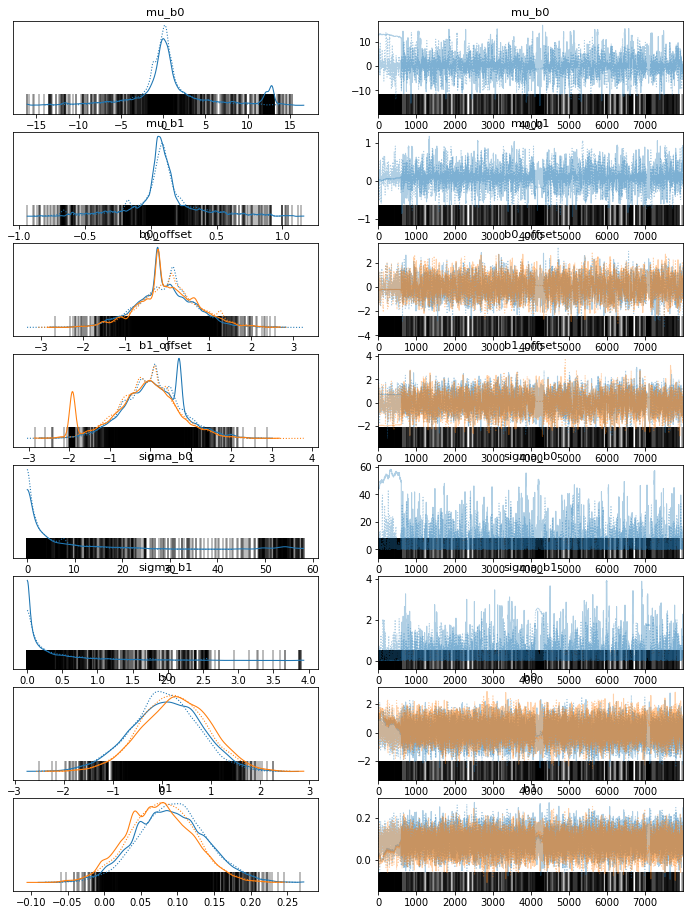

In [43]:
az.plot_trace(trace)

In [44]:
#az.plot_trace(trace, var_names=["mu_b0", "mu_b1", "sigma_b0", "sigma_b1"]);

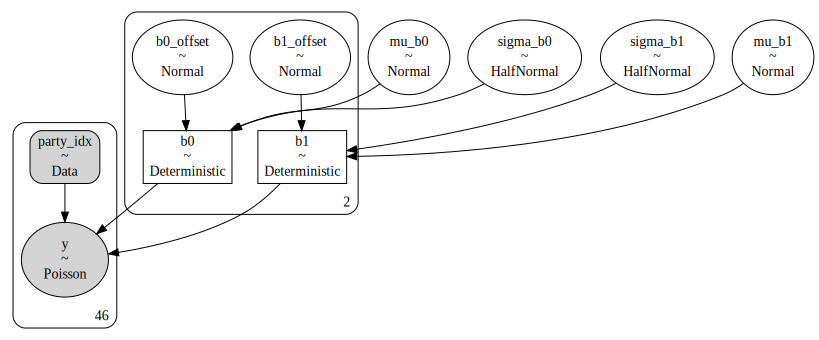

In [45]:
pm.model_to_graphviz(hierarchical_model)

In [46]:
pd.set_option('display.max_rows',None)

In [47]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_b0,0.644,4.438,-5.998,13.110,0.614,0.581,127.0,19.0,1.02
mu_b1,0.084,0.259,-0.468,0.708,0.010,0.007,825.0,595.0,1.00
b0_offset[0],-0.030,0.718,-1.454,1.311,0.015,0.011,2239.0,3070.0,1.00
b0_offset[1],0.042,0.728,-1.298,1.529,0.016,0.011,2025.0,3407.0,1.00
b1_offset[0],0.071,0.733,-1.340,1.454,0.021,0.015,1150.0,2383.0,1.00
b1_offset[1],-0.122,0.809,-1.995,1.147,0.073,0.085,172.0,19.0,1.01
sigma_b0,7.681,11.905,0.000,30.335,2.594,2.136,109.0,17.0,1.02
sigma_b1,0.421,0.581,0.000,1.615,0.036,0.026,136.0,23.0,1.02
b0[0],0.059,0.706,-1.301,1.359,0.026,0.019,700.0,2031.0,1.01
b0[1],0.266,0.688,-1.038,1.544,0.021,0.015,1033.0,2861.0,1.00


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_b0'}>,
        <AxesSubplot:title={'center':'mu_b1'}>,
        <AxesSubplot:title={'center':'b0_offset\n0'}>],
       [<AxesSubplot:title={'center':'b0_offset\n1'}>,
        <AxesSubplot:title={'center':'b1_offset\n0'}>,
        <AxesSubplot:title={'center':'b1_offset\n1'}>],
       [<AxesSubplot:title={'center':'sigma_b0'}>,
        <AxesSubplot:title={'center':'sigma_b1'}>,
        <AxesSubplot:title={'center':'b0\n0'}>],
       [<AxesSubplot:title={'center':'b0\n1'}>,
        <AxesSubplot:title={'center':'b1\n0'}>,
        <AxesSubplot:title={'center':'b1\n1'}>]], dtype=object)

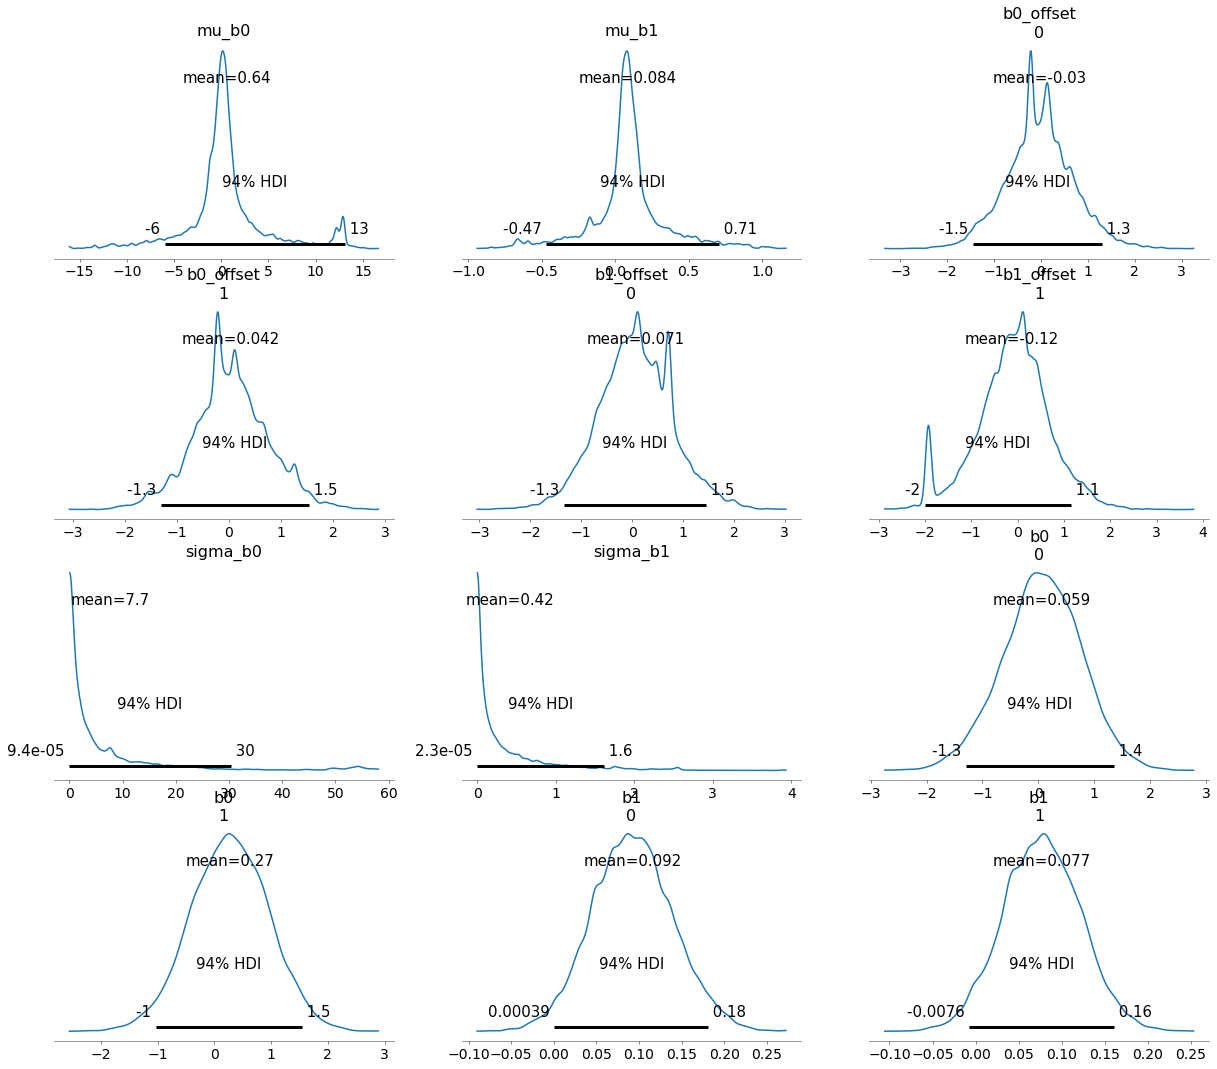

In [48]:
az.plot_posterior(trace) #var_names=["ab"])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<AxesSubplot:ylabel='mu_b1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='b0_offset\n0'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b0_offset\n1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b1_offset\n0'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b1_offset\n1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='sigma_b0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSub

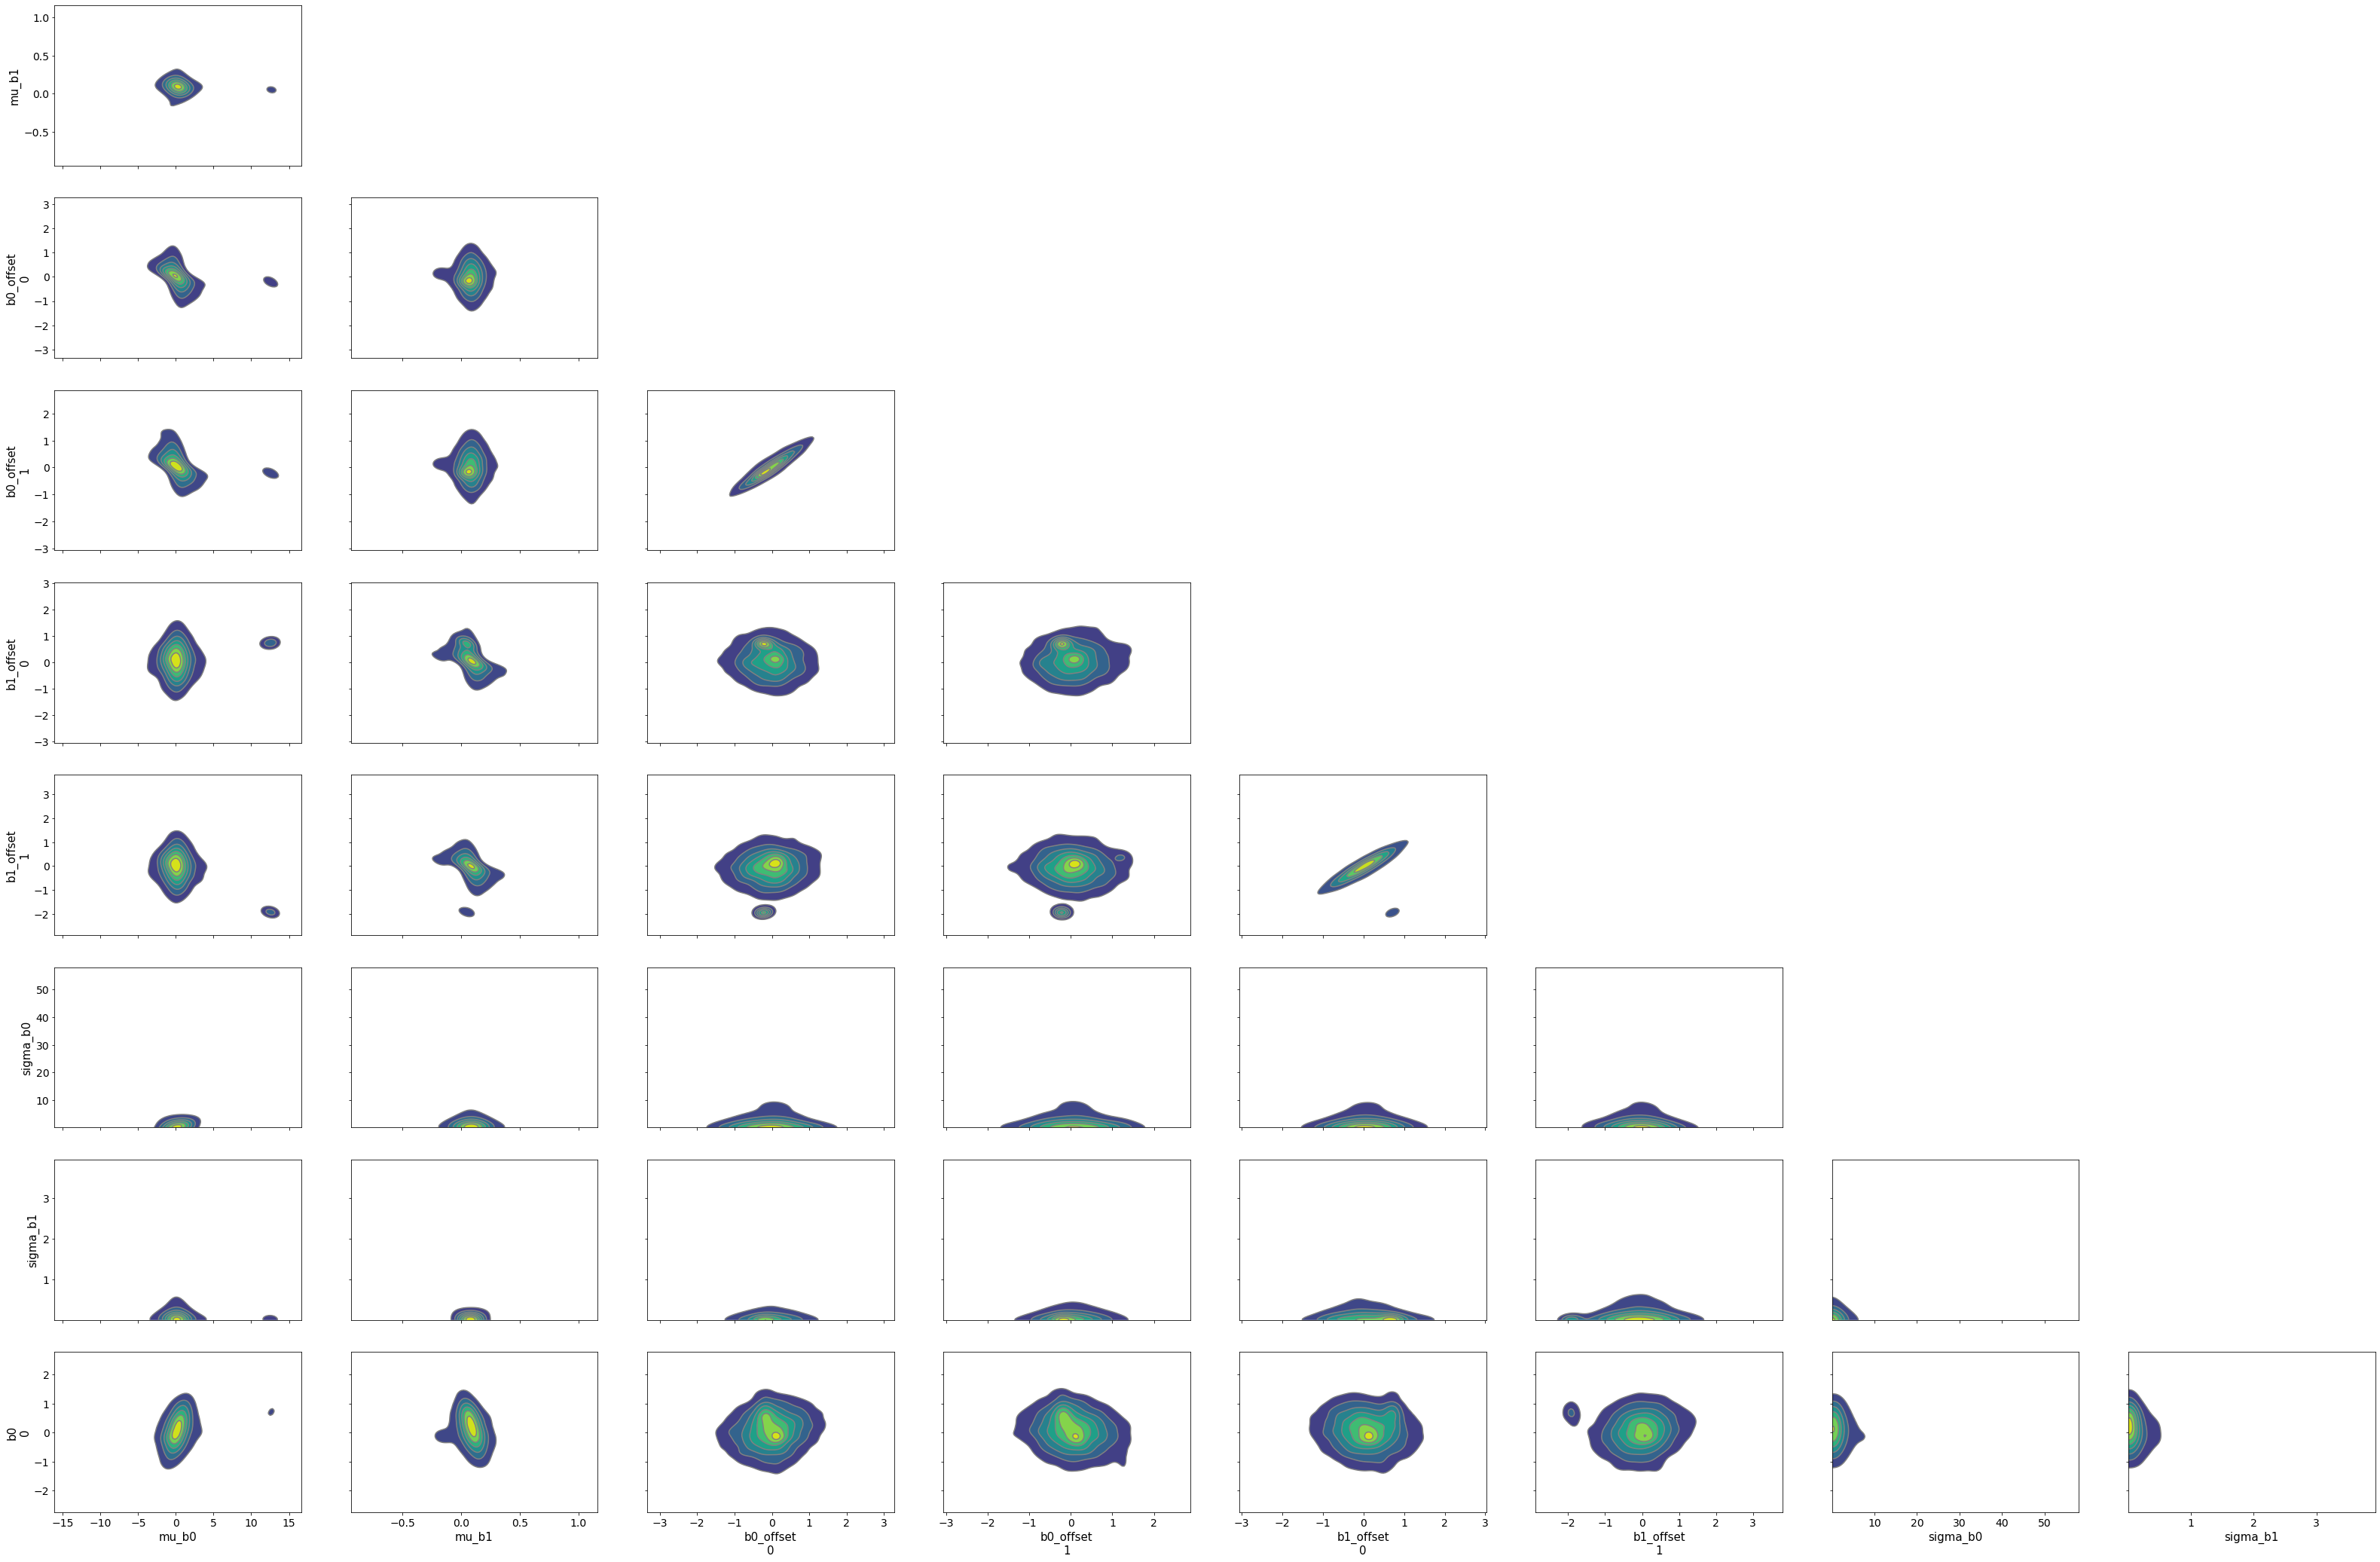

In [49]:
#az.plot_pair(trace, var_names=["X", "Z"], kind="kde")
az.plot_pair(trace, kind="kde")

## Model with the log absolute difference in party spending

In [50]:
#create model (full formulae formulation)
fml = 'log_inv ~ log_diff'

In [51]:
#create design matrices
dm = design_matrices(fml, df, na_action = 'error')

In [52]:
mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

In [53]:
#create model

with pm.Model() as pois_log_diff:
    
    #define priors
    b0 = pm.Normal("intercept", mu = 0, sigma = 10)
    b1 = pm.Normal("log_diff", mu = 0, sigma = 10)

    #define logistic model
    log_lambda = (b0 + b1*df['log_diff'].values)
    
    #define poisson likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df['log_inv'].values)

In [54]:
#sample model
with pois_log_diff:
    test = pm.sample(2000, init='adapt_diag', tune = 2000, target_accept = 0.95)

C:\Users\fav21\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_diff, intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


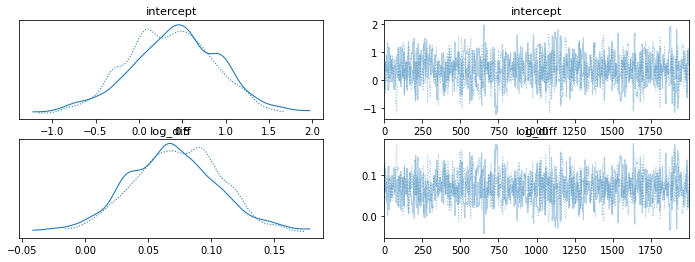

In [55]:
with pois_log_diff:
    az.plot_trace(test)

In [56]:
#with pois_log_diff:
az.summary(test)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.387,0.523,-0.650,1.328,0.021,0.016,636.0,653.0,1.01
log_diff,0.071,0.036,0.002,0.138,0.001,0.001,630.0,642.0,1.01


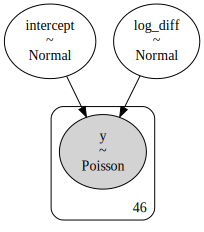

In [57]:
pm.model_to_graphviz(pois_log_diff)

## Now heirarchical ? 

- still a bunch of diverences but the rhats look ok? 
- interesting result -> highed dem intercept but higher slope for repub

In [58]:
df3 = df[['party', 'log_inv', 'log_diff']]

In [59]:
#doesn't create a warning
df3 = df3.assign(party = df3.party.astype('category'))

In [60]:
df3.dtypes

party       category
log_inv      float64
log_diff     float64
dtype: object

In [61]:
df3.head(5)

,party,log_inv,log_diff
0,r,5.273000,13.766415
1,r,2.890372,11.695003
2,b,4.663439,17.194542
3,r,4.844187,12.473199
4,b,6.322565,14.459949


In [62]:
party_idxs, parties = pd.factorize(df3.party)
coords = {
    "party": parties,
    "obs_id": np.arange(len(party_idxs)),
}

In [63]:
# 1 -> blue (dem) 
# 0 -> red (rep)
party_idxs

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1], dtype=int64)

In [64]:
with pm.Model() as hierarchical_model_diff:
    party_idx = pm.Data("party_idx", party_idxs)
    
    # Hyperparameters for groups (states)
    #mu_b0 = pm.Normal("mu_b0", mu=0.0, sigma=100)
    #sigma_b0 = pm.HalfNormal("sigma_b0", 5.0)
    #mu_b1 = pm.Normal("mu_b1", mu=0.0, sigma=100)
    #sigma_b1 = pm.HalfNormal("sigma_b1", 5.0)
    
    mu_b0 = pm.Normal("mu_b0", mu=0.0, sigma=100)
    sigma_b0 = pm.HalfNormal("sigma_b0", 5)
    mu_b1 = pm.Normal("mu_b1", mu=0.0, sigma=100)
    sigma_b1 = pm.HalfNormal("sigma_b1", 5)

    #b0 = pm.Normal("b0", mu=mu_b0, sigma=sigma_b0, shape = df2.log_inv.shape)
    #b1 = pm.Normal("b1", mu=mu_b1, sigma=sigma_b1, shape = df2.log_inv.shape)
    b0 = pm.Normal("b0", mu=mu_b0, sigma=sigma_b0, shape = 2)
    b1 = pm.Normal("b1", mu=mu_b1, sigma=sigma_b1, shape = 2)
    
    #define logistic model
    #log_lambda = b0[party_idxs] + b1[party_idxs] * df2.log_rep.values 
    log_lambda = b0[party_idx] + b1[party_idx] * df3.log_diff.values 
        
    #Data Likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df3.log_inv) 

In [65]:
with hierarchical_model_diff:
        trace = pm.sample(8000, init='adapt_diag', tune = 8000, target_accept = 0.95) 

C:\Users\fav21\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b1, b0, sigma_b1, mu_b1, sigma_b0, mu_b0]


Sampling 2 chains for 8_000 tune and 8_000 draw iterations (16_000 + 16_000 draws total) took 185 seconds.
There were 517 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1775 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7253260380041681, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_b0'}>,
        <AxesSubplot:title={'center':'mu_b0'}>],
       [<AxesSubplot:title={'center':'mu_b1'}>,
        <AxesSubplot:title={'center':'mu_b1'}>],
       [<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>],
       [<AxesSubplot:title={'center':'sigma_b0'}>,
        <AxesSubplot:title={'center':'sigma_b0'}>],
       [<AxesSubplot:title={'center':'sigma_b1'}>,
        <AxesSubplot:title={'center':'sigma_b1'}>]], dtype=object)

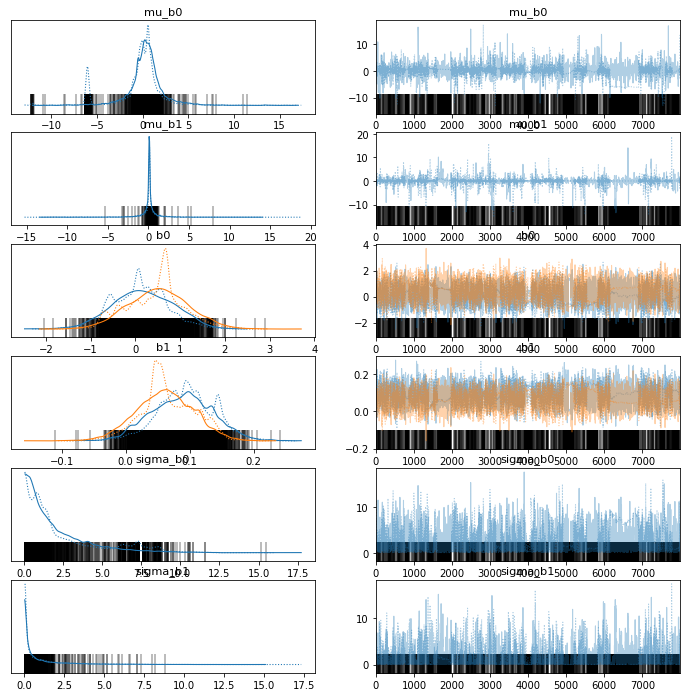

In [66]:
az.plot_trace(trace)

In [67]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fav21\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_b0,-0.029,2.412,-6.260,3.129,0.412,0.294,55.0,35.0,1.04
mu_b1,0.027,1.579,-2.342,2.800,0.044,0.031,1247.0,1628.0,1.02
b0[0],0.129,0.655,-1.052,1.382,0.023,0.016,797.0,1789.0,1.01
b0[1],0.473,0.664,-0.806,1.659,0.029,0.021,540.0,401.0,1.01
b1[0],0.091,0.046,0.004,0.176,0.002,0.001,699.0,1543.0,1.01
b1[1],0.063,0.044,-0.018,0.145,0.002,0.002,570.0,866.0,1.00
sigma_b0,2.220,2.348,0.029,7.250,0.258,0.183,104.0,91.0,1.03
sigma_b1,1.110,1.804,0.012,4.509,0.060,0.043,124.0,223.0,1.04


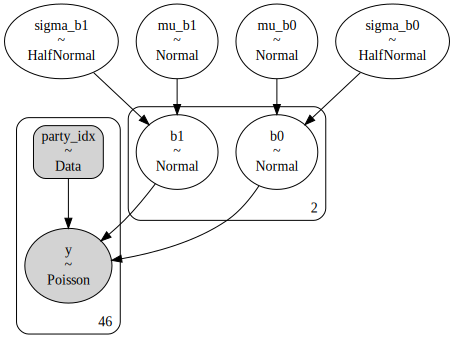

In [68]:
pm.model_to_graphviz(hierarchical_model_diff)